# Data Analysis Notebook V2  - Includes train + test data


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from itertools import compress
from sklearn.ensemble import ExtraTreesRegressor
from scipy.stats import norm
from scipy import spatial

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999


# Section 1: Setting up the data

Loading the data from csv files. Data has been stored as dataframes in pickle and just needs to loaded

In [ ]:
#train_df = pd.read_csv("../data/input/train_2016_v2.csv", parse_dates=["transactiondate"])
#train_df.shape

In [ ]:
#test_df = pd.read_csv("C:\\Users\\lakshay\\Documents\\zes\\zestims\\data\\input\\sample_submission.csv")
#test_df.shape

In [ ]:
#prop_df = pd.read_csv("../data/input/properties_2016.csv")
#prop_df.shape

In [ ]:
# Pickle the data frames
#train_df.to_pickle("C:\\Users\\lakshay\\Documents\\zes\\zestims\\data\\input\\train_df.pkl")
#prop_df.to_pickle("C:\\Users\\lakshay\\Documents\\zes\\zestims\\data\\input\\prop_df.pkl")
#test_df.to_pickle("C:\\Users\\lakshay\\Documents\\zes\\zestims\\data\\input\\test_df.pkl")

Training Data

In [ ]:
# Read dataframes from pickle
train_df = pd.read_pickle("C:\\Users\\lakshay\\Documents\\zes\\zestims\\data\\input\\train_df.pkl")
prop_df = pd.read_pickle("C:\\Users\\lakshay\\Documents\\zes\\zestims\\data\\input\\prop_df.pkl")

In [ ]:
test_df = pd.read_pickle("C:\\Users\\lakshay\\Documents\\zes\\zestims\\data\\input\\test_df.pkl")

In [ ]:
train_df = train_df.merge(prop_df,on='parcelid',how='left')
train_df.head()

In [ ]:
train_df.to_csv("C:\\Users\\lakshay\\Documents\\zes\\zestims\\data\\input\\train_df_1.csv")

Test Data

In [ ]:
test_df = test_df.rename(columns={"ParcelId" : "parcelid"})
test_df_all_data = test_df.merge(prop_df,on='parcelid',how='left')

# Section 2: Missing Data

Understand the handling of missing data

In [ ]:
# Missing features
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

print missing_df['column_name'].count()

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

29 features have more than 50% of the data missing. Refer to the handling of missing data sheet for details to fill the values

# Test Data Analysis

In [ ]:
# Missing features
missing_df_test = test_df_all_data.isnull().sum(axis=0).reset_index()
missing_df_test.columns = ['column_name', 'missing_count']
missing_df_test = missing_df_test.ix[missing_df_test['missing_count']>0]
missing_df_test = missing_df_test.sort_values(by='missing_count')

print missing_df_test['column_name'].count()

ind = np.arange(missing_df_test.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df_test.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df_test.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

Since test and train data have similar missing data ratio, we'll combine both into one dataframe to handle missing data and split later

In [ ]:
test_df_v2 = test_df_all_data.drop(['201610','201611','201612','201710','201711','201712'],axis=1)
test_df_v2.insert(1,"logerror",np.zeros(len(test_df_v2.index.values)))
test_df_v2.insert(2,"transactiondate",np.zeros(len(test_df_v2.index.values)))

Split point for train_test: 90275 (last entry of train data set)

In [ ]:
train_df = pd.concat([train_df,test_df_v2],ignore_index=True)

In [ ]:
#train_df.to_pickle("C:\\Users\\lakshay\\Documents\\zes\\zestims\\data\\input\\train_df_full.pkl")

In [2]:
train_df = pd.read_pickle("C:\\Users\\lakshay\\Documents\\zes\\zestims\\data\\input\\train_df_full.pkl")

In [3]:
train_df.shape

(3075492, 60)

Remove rows with all NANs

In [4]:
all_null_ixs = pd.isnull(train_df["longitude"]).nonzero()[0]
train_df = train_df.drop(all_null_ixs)

In [ ]:
# Zip code distribution - first look
# NOte that zip codes are masked and do not denote the actual values

df_x = train_df2[train_df2["regionidzip"].values<100000]
plt.figure(figsize=(12,8))
g = sns.distplot(df_x.regionidzip.values,fit=norm, bins=100, kde=False )
#g.set(xlim=(90000,110000))
plt.xlabel('Zip', fontsize=12)
plt.show()

# Section 3: Feature Importance

Feature importance results from random forest model. The model was trained on AWS on 16 cores and took about 3 hours. Refer to Lakshay for the details of the model. The results have been imported in this notebook.

In [ ]:
# without transaction month
imp_df = pd.read_csv("C:\\Users\\lakshay\\Documents\\zes\\zestims\\notebooks\\models\\impv2.csv")
imp_df = imp_df.sort_values(by=['%IncMSE'])
imp_df

# For definitions of IncMSe and IncNOdePurity refer to the random forest R importance method

In [ ]:
#plt.bar(imp_df["Name"].values,imp_df["%IncMSE"].values)
a = imp_df["Name"].values
b = imp_df["%IncMSE"].values
names = np.ndarray.tolist(a)
imp = np.ndarray.tolist(b)
y_pos = np.arange(len(names))
plt.figure(figsize=(16,20))
plt.barh(y_pos,imp, align='center', alpha=0.5)
plt.yticks(y_pos, names);
plt.title("IncMSE")

In [ ]:
# with transaction month
imp_df2 = imp_df.sort_values(by=['IncNodePurity'])
a2 = imp_df2["Name"].values
b2 = imp_df2["IncNodePurity"].values
names = np.ndarray.tolist(a2)
imp = np.ndarray.tolist(b2)
y_pos = np.arange(len(names))
plt.figure(figsize=(16,20))
plt.barh(y_pos,imp, align='center', alpha=0.5)
plt.yticks(y_pos, names);
plt.title("IncNodePurity")

In [ ]:
imp_df_nrmlzd = imp_df.copy()
imp_df_nrmlzd["%IncMSE"]= imp_df["%IncMSE"]/imp_df["%IncMSE"].max()
imp_df_nrmlzd["IncNodePurity"]= imp_df["IncNodePurity"]/imp_df["IncNodePurity"].max()
imp_df_nrmlzd["avg"] = (imp_df_nrmlzd["%IncMSE"] + imp_df_nrmlzd["IncNodePurity"])
imp_df_nrmlzd.sort_values(by=["avg"])

In [ ]:
# Scatter of two importance metrics
x = imp_df_nrmlzd["%IncMSE"].values
y = imp_df_nrmlzd["IncNodePurity"].values
ann = imp_df_nrmlzd["Name"].values
plt.figure(figsize=(10,10))
fig,ax = plt.subplots(figsize=(20,20))
ax.scatter(x,y)
ax.set_xlabel("IncMSE")
ax.set_ylabel("IncNodePurity")
plt.title('Feature Importance on both metrics %IncMSE and %IncNodePurity')
for i,txt in enumerate(ann):
    ax.annotate(txt,(x[i],y[i]))

The figure above plots the feature importance with respect to IncMSe and IncNodePurity. Higher the metric more, important it is.

This analysis also includes the importance of transaction month

In [ ]:
imp_df_nrmlzd.to_csv("C:\\Users\\lakshay\\Documents\\zes\\zestims\\notebooks\\models\\imp_plot.csv")

In [ ]:
train_df_4 = pd.DataFrame.from_csv("C:\\Users\\lakshay\\Documents\\zes\\zestims\\notebooks\\models\\train_df_4.csv")

In [ ]:
# Seasonality effects
a = train_df_4.groupby(["transaction_month"]).count()
b1 = a["parcelid"].values
b2 = np.linspace(1,12,12)
plt.figure(figsize=(10,5))
plt.plot(b2,b1,b2,b1,"ro")
plt.xlabel("Month")
plt.ylabel("Num of Transactions")
plt.title("Seasonality")
plt.axvspan(10,12,alpha=0.3,color='red')

# Section 4: Handling Missing Data

# section 4.1: Region City ID  - regionidcity

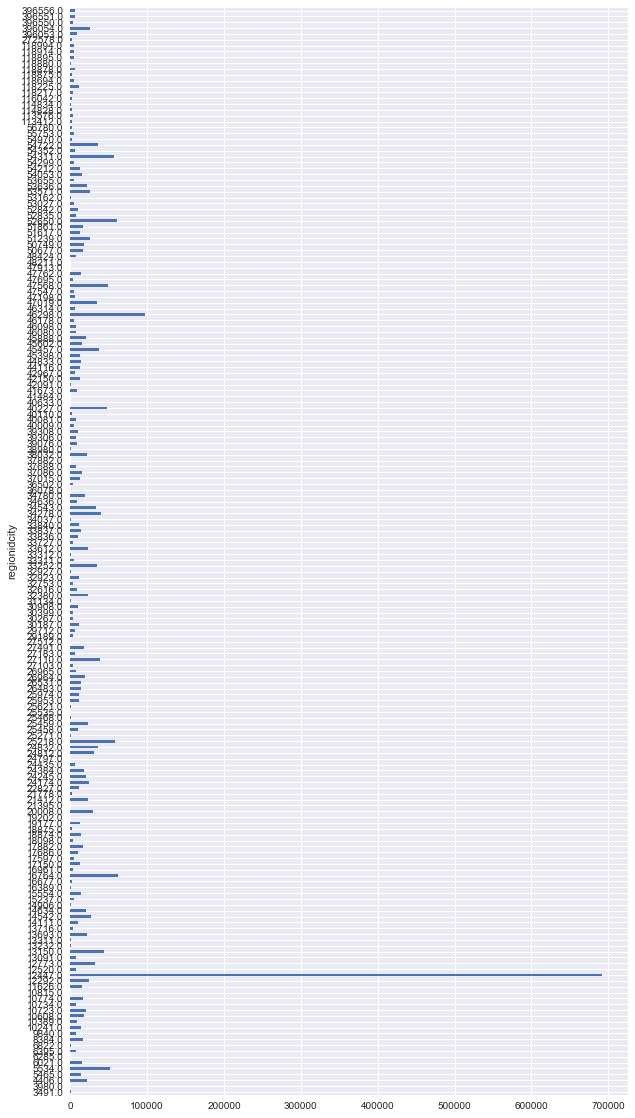

In [6]:
# region_city_id grouping
x_tmp = train_df.groupby(["regionidcity"]).count()
x_tmp['parcelid'].plot(kind='barh',figsize=(10,20))

In [7]:
x_tmp2 = train_df.groupby(["regionidcity"]).count()
x_tmp2["parcelid"].count()

186

In [141]:
# Prep data for SVM classification
train_df_region = train_df[['regionidcity','longitude','latitude']]
missing_region_id = train_df_region.isnull().sum(axis=0).reset_index()
tdf_region_no_null = train_df_region.dropna()
tdf_region_all_null = train_df_region[~train_df_region.isin(tdf_region_no_null).all(1)]

In [9]:
# Training SVM model

#from sklearn import svm

data_tmp = tdf_region_no_null.as_matrix()
y_ids = data_tmp[:,0]
#creating labels from region ids
region_ids = np.unique(y_ids)
labels = np.linspace(1,len(region_ids),len(region_ids))
y = np.zeros(len(y_ids))
for i in range(len(y_ids)):
    y[i] = labels[list(region_ids).index(y_ids[i])]
    
X = data_tmp[:,1:3]

#clf = svm.SVC()
#clf.fit(X,y)
#pickle.dump(clf,open("region_id_svm.sav",'wb'))

In [10]:
# Predicting region id for the missing values

#import pickle
#pickle.dump(clf,open("region_id_svm.sav",'wb'))
#clf = pickle.load(open("C:\\Users\\lakshay\\Documents\\zes\\zestims\\notebooks\\models\\region_id_svm.sav",'rb'))
data_to_predict = tdf_region_all_null.as_matrix()
X_test = data_to_predict[:,1:3]


SVM classification is USELESS!
Let's plot and see what is going on

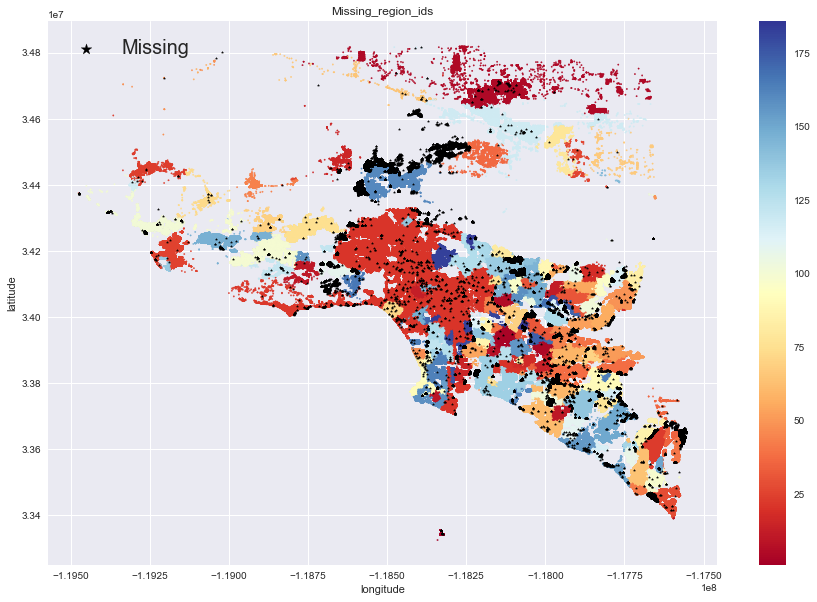

In [11]:
z = y#/177.
cmap = sns.cubehelix_palette(n_colors=186,as_cmap=True)
cm = plt.cm.get_cmap('RdYlBu')

f, ax = plt.subplots(figsize=(15,10))
points = ax.scatter(X[:,0],X[:,1],s=2, c=z, cmap=cm)
ax.scatter(X_test[:,0],X_test[:,1],s=5, c='k', marker='*',label='Missing')
f.colorbar(points)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Missing_region_ids')
plt.legend(loc='upper left',markerscale = 5, prop={'size':20})


# NOTE
# Black points are the missing region ids

Observation:

SVM classification is pretty much useless as all the data points are being classified as just one region id - 20. Need to look more into the decision boundary of the classification in order to understand the classification.

Another approach is to use mean of all the data points in the the region id and classify based on the minimum distance of the unknown point to the respective means of the regions. 

In [ ]:
# Create Tree to be used for clustering applications
tree = spatial.KDTree(zip(train_df_region["longitude"].values,train_df_region["latitude"].values))

In [142]:
# class to classify fields based on clustering
# Classify region ids using nearest region center method

class cluster(object):
    
    def __init__(self,feature,tree=tree):
        self.feature = feature

    def classify(self,x,df,k):
        [m,n] = tree.query(x,k=k)
        near_ids = df[self.feature].iloc[n].values
        near_ids = near_ids[~np.isnan(near_ids)]
        near_ids.tolist()
        a = [int(i) for i in near_ids]
        counts = np.bincount(a)
        try:
            return np.argmax(counts)
        except ValueError:
            pass


In [143]:
region_cluster = cluster("regionidcity")

tdf_region_null_filled = tdf_region_all_null.copy()

iteration = [10,100,500,1000,1500]
t = 0
while train_df_region["regionidcity"].isnull().sum(axis=0) > 0:
    for j in list(tdf_region_null_filled.index.values):
        x = np.array([train_df_region.loc[j]["longitude"],train_df_region.loc[j]["latitude"]])
        train_df_region.loc[j]["regionidcity"] = region_cluster.classify(x,train_df_region,iteration[t])
    
    # Update dataframes 
    tdf_region_no_null = train_df_region.dropna()
    tdf_region_null_filled = train_df_region[~train_df_region.isin(tdf_region_no_null).all(1)]
    print train_df_region["regionidcity"].isnull().sum(axis=0)     
    t += 1

38499
10607
45
0


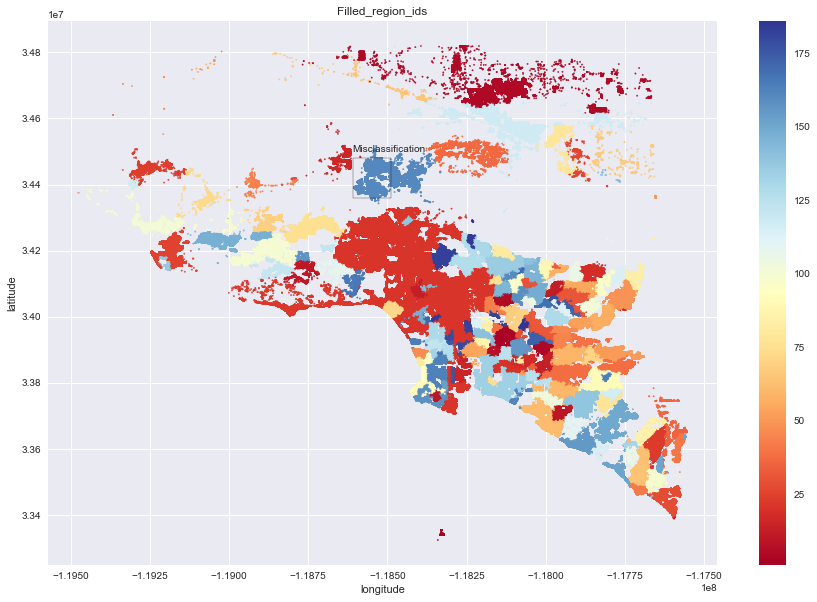

In [147]:
# Plot lat,long with complete data
import matplotlib.patches as patches

#tdf_region_complete = pd.concat([tdf_region_no_null,tdf_region_null_filled])
tdf_region_complete = train_df_region
data_comp = tdf_region_complete.as_matrix()
X2 = data_comp[:,1:3]
y2_ids = data_comp[:,0]

#creating labels from region ids
region_ids = np.unique(y2_ids)
labels = np.linspace(1,len(region_ids),len(region_ids))
y2 = np.zeros(len(y2_ids))
for i in range(len(y2_ids)):
    y2[i] = labels[list(region_ids).index(y2_ids[i])]

z2 = y2
cmap = sns.cubehelix_palette(n_colors=186,as_cmap=True)
cm = plt.cm.get_cmap('RdYlBu')

f, ax = plt.subplots(figsize=(15,10))
points = ax.scatter(X2[:,0],X2[:,1],s=2, c=z2, cmap=cm)
f.colorbar(points)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Filled_region_ids')


# section 4.2: Region Zip Id  - regionidzip

In [ ]:
# region_zip_id grouping
x_tmp = train_df.groupby(["regionidzip"]).count()
#x_tmp['parcelid'].plot(kind='barh',figsize=(10,30))
#x_tmp['parcelid']

In [ ]:
# Prep data 
train_df_zip = train_df[['regionidzip','longitude','latitude']]
missing_zip_id = train_df_zip.isnull().sum(axis=0).reset_index()
tdf_zip_no_null = train_df_zip.dropna()
tdf_zip_all_null = train_df_zip[~train_df_zip.isin(tdf_zip_no_null).all(1)]

In [ ]:
data_zip_tmp = tdf_zip_no_null.as_matrix()
y_zip_ids = data_zip_tmp[:,0]
#creating labels from region ids
zip_ids = np.unique(y_zip_ids)
labels = np.linspace(1,len(zip_ids),len(zip_ids))
y_zip = np.zeros(len(y_zip_ids))
for i in range(len(y_zip_ids)):
    y_zip[i] = labels[list(zip_ids).index(y_zip_ids[i])]
    
X_zip = data_zip_tmp[:,1:3]

missing_data = tdf_zip_all_null.as_matrix()
X_zip_missing = missing_data[:,1:3]

z_zip = y_zip
cmap = sns.cubehelix_palette(n_colors=388,as_cmap=True)
cm = plt.cm.get_cmap('RdYlBu')

f, ax = plt.subplots(figsize=(15,10))
points = ax.scatter(X_zip[:,0],X_zip[:,1],s=2, c=z_zip, cmap=cm)
ax.scatter(X_zip_missing[:,0],X_zip_missing[:,1],s=40, c='k', marker='*',label='Missing')
f.colorbar(points)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Missing_zip_ids')
plt.legend(loc='upper left',markerscale = 2, prop={'size':20})


In [ ]:
# Classify zip ids using nearest region center method

zip_location_mean = np.zeros(shape=(len(zip_ids),2))

for idx,val in enumerate(zip_ids):
    df_tmp = train_df_zip[train_df_zip["regionidzip"]==val]
    inp_zip_location = df_tmp.as_matrix()[:,1:3]
    zip_mean_tmp = inp_zip_location.mean(axis=0)
    zip_location_mean[idx,:] = zip_mean_tmp
    
tdf_zip_null_filled = tdf_zip_all_null.copy()

def classify_zip(x,zip_location_mean=zip_location_mean,zip_ids=zip_ids):
    
    dist = np.zeros(len(zip_ids))
    for i in range(zip_location_mean.shape[0]):
        dist[i] = np.sqrt(np.sum(np.square(x-zip_location_mean[i,:])))
    
    return  zip_ids[np.argmin(dist)]   
  
    
for j in list(tdf_zip_null_filled.index.values):
    x = np.array([tdf_zip_null_filled.ix[j]["longitude"],tdf_zip_null_filled.ix[j]["latitude"]])
    tdf_zip_null_filled.ix[j]["regionidzip"] = classify_zip(x)
    

In [ ]:
# Plot lat,long with complete data
import matplotlib.patches as patches

tdf_zip_complete = pd.concat([tdf_zip_no_null,tdf_zip_null_filled])
data_zip_comp = tdf_zip_complete.as_matrix()
X2_zip = data_zip_comp[:,1:3]
y2_zip_ids = data_zip_comp[:,0]

#creating labels from region ids
zip_ids = np.unique(y2_zip_ids)
labels = np.linspace(1,len(zip_ids),len(zip_ids))
y2_zip = np.zeros(len(y2_zip_ids))
for i in range(len(y2_zip_ids)):
    y2_zip[i] = labels[list(zip_ids).index(y2_zip_ids[i])]

z2_zip = y2_zip
cmap = sns.cubehelix_palette(n_colors=388,as_cmap=True)
cm = plt.cm.get_cmap('RdYlBu')

f, ax = plt.subplots(figsize=(15,10))
points = ax.scatter(X2_zip[:,0],X2_zip[:,1],s=2, c=z2_zip, cmap=cm)
f.colorbar(points)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Filled_zip_ids')


In [ ]:
# Save complete dataframes
tdf_zip_complete.to_pickle('C:\\Users\\lakshay\\Documents\\zes\\zestims\\notebooks\\models\\tdf_zip_complete.pkl')
tdf_region_complete.to_pickle('C:\\Users\\lakshay\\Documents\\zes\\zestims\\notebooks\\models\\tdf_region_complete.pkl')

# section 4.3: Full Bathroom Count - fullbathcnt

Calculate using bathroomcnt which includes half bathrooms as well

In [ ]:
diff = train_df["bathroomcnt"].values - train_df["fullbathcnt"].values
diff_sorted = np.sort(diff)
null_vals = diff_sorted[np.isnan(diff_sorted)]
diff_no_null = diff_sorted[~np.isnan(diff_sorted)]
x = np.arange(0, len(diff_no_null), 1)
print("Number of NANs in fullbathcnt: %i"%len(null_vals))

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(x,diff_no_null)
plt.xlabel("Number of parcels")
plt.ylabel("Diff")
plt.title("Difference between full_bath_cnt and total_bath_cnt")
diff_a = diff_no_null[x in diff_no_null[x]>=1.5]
print("Number of values with diff greater than 0.5: %i"%len(diff_a))

Assumption:
If the difference between total_bath_cnt and full_bath_cnt is 0.5 then it is highly likely that full_bath_count is floor(total_bath_count). For example, if total_bath_cnt is 2.5, full_bath_cnt should be 2.

It is seen only 7 or 0.007% values in the difference are above 1.5. Hence the above assumption is reasonable given 99.993% values have the difference of 0.5 or less. The missing values for full_bath_cnt can be filled with floor(bathroomcnt)

*total_bath_cnt is same as bathroomcnt

In [ ]:
df_fullbathcnt = train_df[["fullbathcnt","bathroomcnt"]]
df_fullbathcnt_no_null = df_fullbathcnt.dropna()
df_fullbathcnt_all_null = df_fullbathcnt[~df_fullbathcnt.isin(df_fullbathcnt_no_null).all(1)]
fullbathcnt_null_ix = df_fullbathcnt_all_null.index.values
df_fullbathcnt_all_null

In [ ]:
train_df.ix[126]

Rows with fullbathcnt missing, have majority of fields missing too. Check the above the output. 1182 of 90k such rows can be ignored (atleast to begin with) 

Data_v2 : Removed missing values described above

In [ ]:
#train_df_v2 = train_df.drop(train_df.index[fullbathcnt_null_ix])
#train_df_v2.to_pickle("C:\\Users\\lakshay\\Documents\\zes\\zestims\\data\\input\\train_df_v2.pkl")

In [ ]:
train_df_v2 = pd.read_pickle("C:\\Users\\lakshay\\Documents\\zes\\zestims\\data\\input\\train_df_v2.pkl")

In [ ]:
train_df_v2["basementsqft"] = train_df_v2.basementsqft.replace(np.NaN,0)
train_df_v2["taxdelinquencyflag"] = train_df_v2.taxdelinquencyflag.replace(np.NaN,0)
train_df_v2["taxdelinquencyyear"] = train_df_v2.taxdelinquencyyear.replace(np.NaN,0)

In [ ]:
train_df["storytypeid"].isnull().sum(axis=0)

In [ ]:
from scipy import spatial
x,y = np.mgrid[0:5,2:8]
tree = spatial.KDTree(zip(x.ravel(),y.ravel()))
pts = np.array([2.5,5])
tree.query(pts,k=4)
                    

In [ ]:
tree.data[15,:]

In [13]:
#train_df_region
from scipy import spatial
tree = spatial.KDTree(zip(train_df_region["longitude"].values,train_df_region["latitude"].values))
[m,n] = tree.query([-118488536.,34280990.],k=4)

In [54]:
tdf_region_all_null.loc[155]

regionidcity            NaN
longitude      -118362979.0
latitude         34280514.0
Name: 155, dtype: float64